In [70]:
import pycaret
import pandas as pd

In [71]:
train = pd.read_csv('Train.csv')
train = train.drop(columns=['Unnamed: 0'])
train

,DATETIMEDATA,PM25,CO,NO2,TEMP,RH
0,2024-01-01 00:00:00,31.5,0.63,10.00,27,95
1,2024-01-01 01:00:00,35.5,0.61,11.00,27,96
2,2024-01-01 02:00:00,28.3,0.50,5.29,27,93
3,2024-01-01 03:00:00,22.2,0.44,3.00,27,92
4,2024-01-01 04:00:00,27.4,0.43,1.00,26,93
...,...,...,...,...,...,...
898,2024-02-14 11:00:00,32.4,0.53,4.00,33,52
899,2024-02-14 12:00:00,22.1,0.52,4.00,34,49
900,2024-02-14 13:00:00,26.3,0.53,4.00,35,48
901,2024-02-14 14:00:00,21.2,0.52,7.00,36,46


In [72]:
test = pd.read_csv('Test.csv')
test = test.drop(columns=['Unnamed: 0'])
test

,DATETIMEDATA,PM25,CO,NO2,TEMP,RH
0,2024-02-14 16:00:00,26.5,0.55,7.0,35,46
1,2024-02-14 17:00:00,23.7,0.54,10.0,35,47
2,2024-02-14 18:00:00,24.4,0.54,8.0,32,53
3,2024-02-14 19:00:00,25.3,0.59,8.0,32,57
4,2024-02-14 20:00:00,22.6,0.49,7.0,31,60
...,...,...,...,...,...,...
387,2024-03-01 19:00:00,28.7,0.60,12.0,31,65
388,2024-03-01 20:00:00,33.9,0.57,11.0,30,66
389,2024-03-01 21:00:00,30.3,0.53,9.0,30,66
390,2024-03-01 22:00:00,27.5,0.46,6.0,30,66


In [73]:
from pycaret.regression import *
train['DATETIMEDATA'] = pd.to_datetime(train['DATETIMEDATA'])
setup_Model1Day = setup(train, target='PM25', session_id=102)

,Description,Value
0,Session id,102
1,Target,PM25
2,Target type,Regression
3,Original data shape,"(903, 6)"
4,Transformed data shape,"(903, 8)"
5,Transformed train set shape,"(632, 8)"
6,Transformed test set shape,"(271, 8)"
7,Numeric features,4
8,Date features,1
9,Preprocess,True


In [74]:
best_Model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,3.2545,19.9785,4.4019,0.5707,0.1376,0.1141,0.0250
catboost,CatBoost Regressor,3.3042,20.7498,4.4615,0.5587,0.1401,0.1153,0.1790
lightgbm,Light Gradient Boosting Machine,3.3746,21.4912,4.5445,0.5417,0.1437,0.1183,0.0790
rf,Random Forest Regressor,3.4929,23.1041,4.7374,0.5014,0.1478,0.1224,0.0320
gbr,Gradient Boosting Regressor,3.5034,22.9901,4.7350,0.5001,0.1466,0.1223,0.0150
xgboost,Extreme Gradient Boosting,3.6997,27.8388,5.1872,0.3993,0.1565,0.1276,0.0200
knn,K Neighbors Regressor,4.0020,28.3062,5.2454,0.3898,0.1696,0.1428,0.0110
lr,Linear Regression,4.1824,27.9744,5.2342,0.3881,0.1710,0.1493,0.3050
br,Bayesian Ridge,4.1883,27.9984,5.2356,0.3880,0.1712,0.1496,0.0060
lar,Least Angle Regression,4.1908,28.1921,5.2501,0.3841,0.1718,0.1494,0.0060


In [75]:
prediction = predict_model(best_Model)
prediction.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,3.0591,17.8200,4.2214,0.5813,0.1431,0.1131


,DATETIMEDATA,CO,NO2,TEMP,RH,PM25,prediction_label
698,2024-02-06 03:00:00,0.52,7.00,27,82,29.100000,32.450001
517,2024-01-29 14:00:00,0.46,5.00,34,51,18.299999,20.915000
36,2024-01-02 12:00:00,0.41,4.00,34,55,18.000000,15.905000
674,2024-02-05 03:00:00,0.67,4.00,28,75,37.200001,40.111001
459,2024-01-27 04:00:00,0.35,5.29,27,76,20.100000,24.036000


In [76]:
et_model = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.9974,15.5534,3.9438,0.6378,0.1230,0.1008
1,3.2886,21.0934,4.5928,0.5939,0.1357,0.1088
2,2.9853,15.8320,3.9789,0.5931,0.1289,0.1053
3,3.6302,21.0634,4.5895,0.5201,0.1562,0.1358
4,2.4214,11.9001,3.4497,0.6233,0.1035,0.0791
5,4.0608,31.0594,5.5731,0.4749,0.1666,0.1387
6,3.8418,35.5754,5.9645,0.4820,0.1637,0.1332
7,3.1486,16.1847,4.0230,0.6037,0.1370,0.1149
8,3.3674,18.7558,4.3308,0.5131,0.1360,0.1184


In [77]:
tuned_model = tune_model(et_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.4966,18.8935,4.3467,0.5600,0.1347,0.1141
1,3.7076,26.6898,5.1662,0.4861,0.1536,0.1226
2,3.4133,20.9545,4.5776,0.4615,0.1474,0.1189
3,3.8691,22.4077,4.7337,0.4895,0.1639,0.1456
4,3.0906,14.5168,3.8101,0.5405,0.1248,0.1032
5,4.3895,35.8456,5.9871,0.3940,0.1736,0.1450
6,4.7497,43.3096,6.5810,0.3694,0.1916,0.1700
7,3.1835,15.6360,3.9542,0.6171,0.1334,0.1145
8,3.3785,17.3955,4.1708,0.5485,0.1374,0.1212


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [78]:
improved_model = ensemble_model(tuned_model,n_estimators=20)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.9396,14.9748,3.8697,0.6513,0.1207,0.0979
1,3.2964,21.8888,4.6785,0.5785,0.1381,0.1093
2,3.0973,17.5268,4.1865,0.5496,0.1336,0.1085
3,3.5965,20.6951,4.5492,0.5285,0.1554,0.1348
4,2.3873,10.5265,3.2445,0.6668,0.1017,0.0791
5,4.1095,32.1464,5.6698,0.4565,0.1681,0.1398
6,4.1367,38.5017,6.2050,0.4394,0.1739,0.1449
7,2.9355,14.7089,3.8352,0.6398,0.1316,0.1081
8,3.1453,15.3852,3.9224,0.6006,0.1297,0.1134


In [79]:
now = pd.Timestamp.now()
start_date = now.date()
end_date = start_date + pd.DateOffset(days=7)
future_dates = pd.date_range(start=start_date, end=end_date, freq='D')

In [91]:
predicted_data = pd.DataFrame({'DATETIMEDATA': future_dates})
predicted_data['CO'] = train['CO'].mean().round(2)
predicted_data['NO2'] = train['NO2'].mean().round(2)
predicted_data['TEMP'] = train['TEMP'].mean().round(2)
predicted_data['RH'] = train['RH'].mean().round(2)

In [92]:
predictions = predict_model(tuned_model, data=predicted_data)
pred = pd.DataFrame(predictions, columns=['DATETIMEDATA', 'prediction_label'])
pred["prediction_label"] = pred["prediction_label"].round(2)
pred

,DATETIMEDATA,prediction_label
0,2024-03-12,31.69
1,2024-03-13,31.39
2,2024-03-14,31.05
3,2024-03-15,31.05
4,2024-03-16,31.05
5,2024-03-17,31.05
6,2024-03-18,31.05
7,2024-03-19,31.05


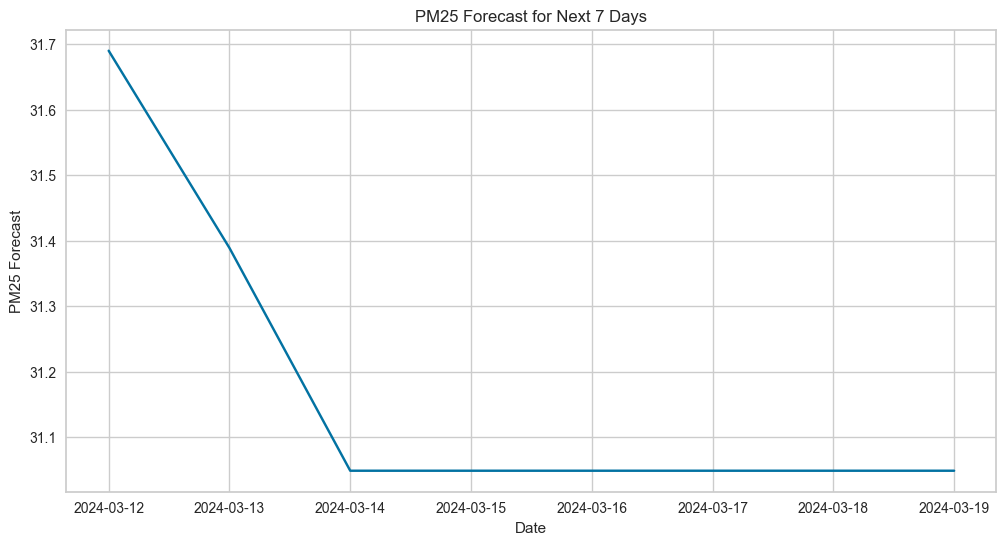

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions['prediction_label'])
plt.xlabel('Date')
plt.ylabel('PM25 Forecast')
plt.title('PM25 Forecast for Next 7 Days')
plt.grid(True)
plt.show()

In [94]:
save_model(improved_model, 'PM25_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['DATETIMEDATA'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['CO', 'NO2', 'TEMP', 'RH'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('trained_model',
                  BaggingRegressor(estimator=ExtraTreesRegressor(n_jobs=-1,
                                                                 random_state=102),
                                   n_estimators=20, random_state=102))]),
 'PM25_pipeline.pkl')

In [95]:
load_model('PM25_pipeline')

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\nong9\AppData\Local\Temp\joblib),
         steps=[('date_feature_extractor',
                 TransformerWrapper(include=['DATETIMEDATA'],
                                    transformer=ExtractDateTimeFeatures())),
                ('numerical_imputer',
                 TransformerWrapper(include=['CO', 'NO2', 'TEMP', 'RH'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('trained_model',
                 BaggingRegressor(estimator=ExtraTreesRegressor(n_jobs=-1,
                                                                random_state=102),
                                  n_estimators=20, random_state=102))])